# Readout simulation

## Initialization

In [17]:
import readout as RO
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import ode, quad
from scipy.stats import norm
import numpy as np
from numpy import random

### - System parameters

In [61]:
g = 45e6 # Transmon-cavity coupling strength (Hz)
delta = 380e6*5 # Transmon-cavity detuning (0z)
chi = 2*np.pi*g**2/delta
kappa = 1.5*chi
T1e = 7e-6   # Characteristic time of e -> g transmon transition 
T1g = 1   # Characteristic time of g -> e transmon transition 

In [62]:
kappa/2/np.pi/1e6

1.5986842105263157

### - Simulation parameters

In [149]:
alpha_0 = 0   # Initial cavity state
t_sim = 12000e-10 # Simulation time > 20/chi
dt = 1e-10   # Simulation timestep

freq_mm = 0   # Frequency mismatch between input signal and cavity (Hz)
A = 1.5   # Input signal amplitude
pulse_duration = 200e-9   # Pulse duration

# Input signal (square pulse)
def b_in(t):

    # Pulse start time
    t0 = 10e-9
    
    # Pulse stop time
    tf = t0 + pulse_duration
    
    if t > t0 and t < tf:
        return A*np.exp(1j*2*np.pi*freq_mm*t)

    else:
        return 0 

## Readout dynamics
Instantiation of readout_simulation object

In [150]:
sim = RO.readout_simulation(b_in, freq_mm, chi, kappa, T1e, T1g, alpha_0, t_sim, dt)

# Dynamics when transmon is in excited state (q_state = 1)
q_state = 1
b_out_e, cavity_alpha_e, t_rng = sim.simulate_cavity_dynamics(q_state)

# Dynamics when transmon is in ground state (q_state = 0)
q_state = 0
b_out_g, cavity_alpha_g, t_rng = sim.simulate_cavity_dynamics(q_state)

### - Input signal plot
sim.b_int(t)

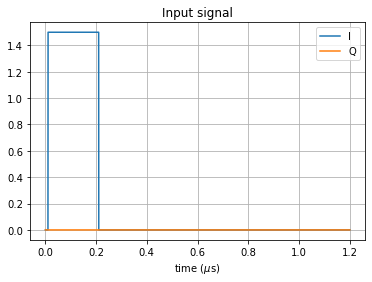

In [151]:
fig, ax = plt.subplots()

ax.plot([t*1e6 for t in t_rng], [sim.b_in(t).real for t in t_rng], label = 'I')
ax.plot([t*1e6 for t in t_rng], [sim.b_in(t).imag for t in t_rng], label = 'Q')
ax.set_xlabel('time ($\mu$s)')
ax.set_title('Input signal')
ax.grid()
ax.legend()

plt.show()

### - Cavity state plot
sim.cavity_alpha

C:\Users\qcrew\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


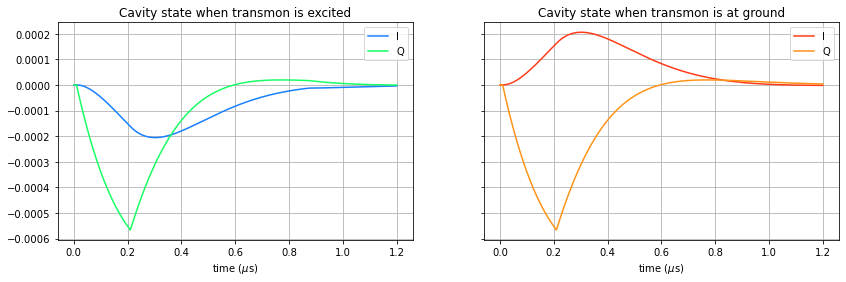

In [152]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,4))

ax1.plot([t*1e6 for t in t_rng], [x.real for x in cavity_alpha_e], label = 'I', c = '#177FFF')
ax1.plot([t*1e6 for t in t_rng], [x.imag for x in cavity_alpha_e], label = 'Q', c = '#17FF64')
ax1.set_xlabel('time ($\mu$s)')
ax1.set_title('Cavity state when transmon is excited')
ax1.grid()
ax1.legend()

ax2.plot([t*1e6 for t in t_rng], [x.real for x in cavity_alpha_g], label = 'I', c = '#FF3A17')
ax2.plot([t*1e6 for t in t_rng], [x.imag for x in cavity_alpha_g], label = 'Q', c = '#FF9317')
ax2.set_xlabel('time ($\mu$s)')
ax2.set_title('Cavity state when transmon is at ground')
ax2.grid()
ax2.legend()

plt.show()

### - Output signal plot
sim.b_out

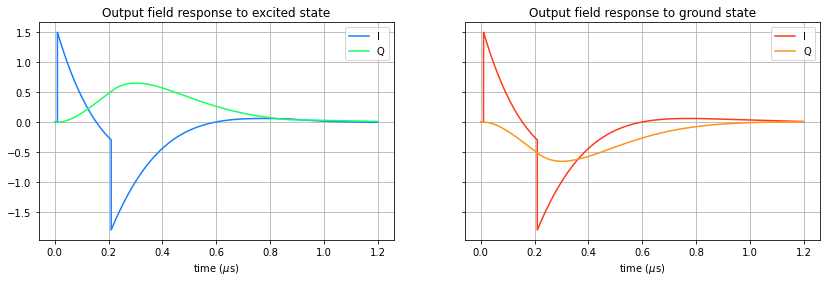

In [153]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,4))

ax1.plot([t*1e6 for t in t_rng], [x.real for x in b_out_e], label = 'I', c = '#177FFF')
ax1.plot([t*1e6 for t in t_rng], [x.imag for x in b_out_e], label = 'Q', c = '#17FF64')
ax2.plot([t*1e6 for t in t_rng], [x.real for x in b_out_g], label = 'I', c = '#FF3A17')
ax2.plot([t*1e6 for t in t_rng], [x.imag for x in b_out_g], label = 'Q', c = '#FF9317')

ax1.set_xlabel('time ($\mu$s)')
ax1.set_title('Output field response to excited state')
ax1.grid()
ax1.legend()

ax2.set_xlabel('time ($\mu$s)')
ax2.set_title('Output field response to ground state')
ax2.grid()
ax2.legend()

plt.show()

## Noisy acquisition of output signal
sim.b_signal_proc() function

In [154]:
# Measurement parameters
t_wait = 250e-9    # waiting time
t_acq = 100e-9    # sampling time
dt_acq = 20e-9    # sampling interval

acq_b_out_e, dsp_b_out_e, noisy_dsp_b_out_e, acq_time = sim.digital_signal_processing(b_out_e, t_rng, t_wait, t_acq, dt_acq)
acq_b_out_g, dsp_b_out_g, noisy_dsp_b_out_g, acq_time = sim.digital_signal_processing(b_out_g, t_rng, t_wait, t_acq, dt_acq)

### - Acquisition of b_out and plot in IQ plane
acq_b_out

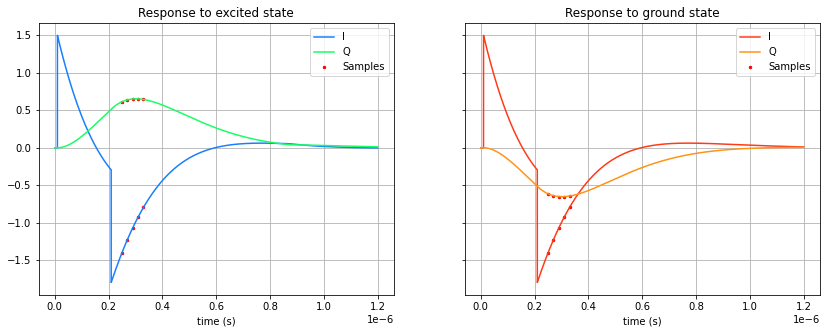

In [155]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(14,5))

ax1.plot(t_rng, [x.real for x in b_out_e], label = 'I', c = '#177FFF')
ax1.plot(t_rng, [x.imag for x in b_out_e], label = 'Q', c = '#17FF64')
ax1.scatter(acq_time, [x.real for x in acq_b_out_e], c = 'r', label = 'Samples', s = 6)
ax1.scatter(acq_time, [x.imag for x in acq_b_out_e], c = 'r', s = 6)

ax2.plot(t_rng, [x.real for x in b_out_g], label = 'I', c = '#FF3A17')
ax2.plot(t_rng, [x.imag for x in b_out_g], label = 'Q', c = '#FF9317')
ax2.scatter(acq_time, [x.real for x in acq_b_out_g], c = 'r', label = 'Samples', s = 6)
ax2.scatter(acq_time, [x.imag for x in acq_b_out_g], c = 'r', s = 6)

ax1.set_xlabel('time (s)')
ax1.set_title('Response to excited state')
ax1.grid()
ax1.legend()

ax2.set_xlabel('time (s)')
ax2.set_title('Response to ground state')
ax2.grid()
ax2.legend()

plt.show()

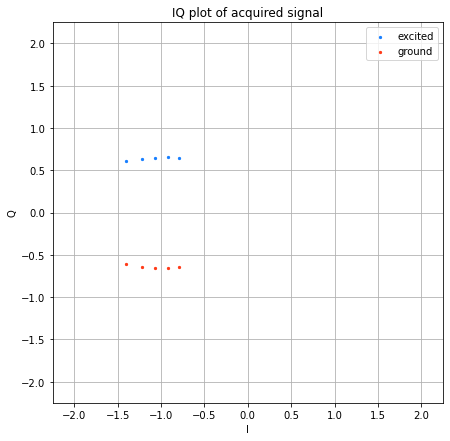

In [156]:
f, ax = plt.subplots(figsize=(7,7))

ax.scatter([x.real for x in acq_b_out_e], [x.imag for x in acq_b_out_e], label = 'excited', c = '#177FFF', s = 5)
ax.scatter([x.real for x in acq_b_out_g], [x.imag for x in acq_b_out_g], label = 'ground', c = '#FF3A17', s = 5)

ax.set_ylim([-1.5*A, 1.5*A])
ax.set_xlim([-1.5*A, 1.5*A])
ax.set_xlabel('I')
ax.set_ylabel('Q')
ax.set_title('IQ plot of acquired signal')
ax.legend()
ax.grid()

plt.show()

### - Removal of frequency mismatch from acquired b_out and plot in IQ plane
proc_b_out

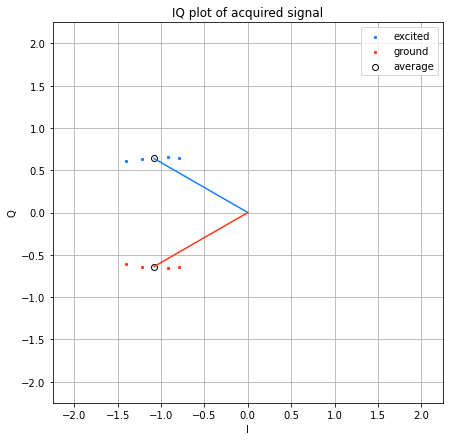

In [157]:
f, ax = plt.subplots(figsize=(7,7))

# Plot noisy data
b_avg_e = np.mean(dsp_b_out_e)
b_avg_g = np.mean(dsp_b_out_g)

ax.scatter([x.real for x in dsp_b_out_e], [x.imag for x in dsp_b_out_e], label = 'excited', c = '#177FFF', s = 5)
ax.scatter([x.real for x in dsp_b_out_g], [x.imag for x in dsp_b_out_g], label = 'ground', c = '#FF3A17', s = 5)

ax.plot([0, b_avg_e.real], [0, b_avg_e.imag], c = '#177FFF')
ax.scatter([b_avg_e.real], [b_avg_e.imag], edgecolors = 'k', c = 'w')

ax.plot([0, b_avg_g.real], [0, b_avg_g.imag], c = '#FF3A17')
ax.scatter([b_avg_g.real], [b_avg_g.imag], edgecolors = 'k', c = 'w', label = 'average')

ax.set_ylim([-1.5*A, 1.5*A])
ax.set_xlim([-1.5*A, 1.5*A])
ax.set_xlabel('I')
ax.set_ylabel('Q')
ax.set_title('IQ plot of acquired signal')
ax.legend()
ax.grid()

plt.show()

### - IQ plane plot of post-processed b_out with addition of noise 
noisy_proc_b_out

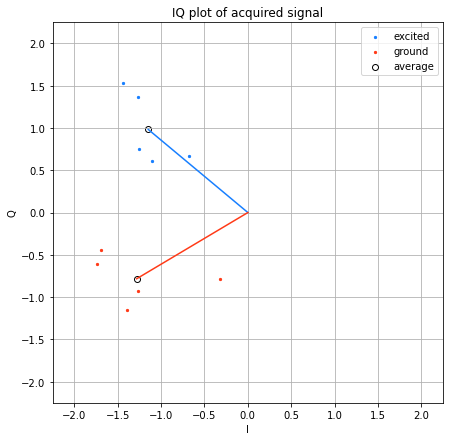

In [158]:
f, ax = plt.subplots(figsize=(7,7))

# Plot noisy data
noisy_avg_e = np.mean(noisy_dsp_b_out_e)
noisy_avg_g = np.mean(noisy_dsp_b_out_g)

ax.scatter([x.real for x in noisy_dsp_b_out_e], [x.imag for x in noisy_dsp_b_out_e], label = 'excited', c = '#177FFF', s = 5)
ax.scatter([x.real for x in noisy_dsp_b_out_g], [x.imag for x in noisy_dsp_b_out_g], label = 'ground', c = '#FF3A17', s = 5)

ax.plot([0, noisy_avg_e.real], [0, noisy_avg_e.imag], c = '#177FFF')
ax.scatter([noisy_avg_e.real], [noisy_avg_e.imag], edgecolors = 'k', c = 'w')

ax.plot([0, noisy_avg_g.real], [0, noisy_avg_g.imag], c = '#FF3A17')
ax.scatter([noisy_avg_g.real], [noisy_avg_g.imag], edgecolors = 'k', c = 'w', label = 'average')

ax.set_ylim([-1.5*A, 1.5*A])
ax.set_xlim([-1.5*A, 1.5*A])
ax.set_xlabel('I')
ax.set_ylabel('Q')
ax.set_title('IQ plot of acquired signal')
ax.legend()
ax.grid()

plt.show()

### - Projection of acquired data onto theoretically estimated separatrix

In [159]:
theta_e, theta_g = sim.exp_theta['e'], sim.exp_theta['g']
exp_e = np.exp(1j*np.pi*theta_e/180)
exp_g = np.exp(1j*np.pi*theta_g/180)
separatrix = 1j*(exp_e + exp_g)/np.absolute(exp_e + exp_g)
separatrix /= np.absolute(separatrix)

### - IQ plane plot of post-processed b_out with addition of noise 
noisy_proc_b_out

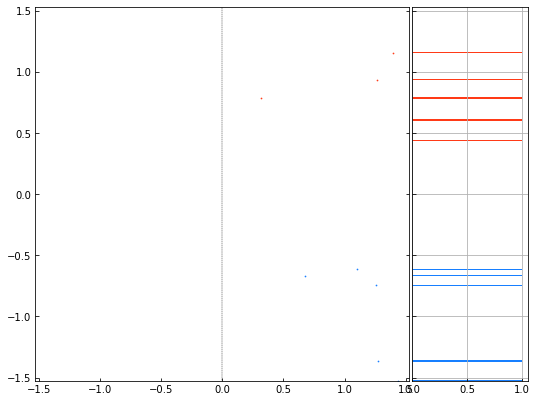

In [161]:
# Projection over the separatrix
signal_e = [(x.real*separatrix.real + x.imag*separatrix.imag)[0] for x in noisy_dsp_b_out_e]
signal_g = [(x.real*separatrix.real + x.imag*separatrix.imag)[0] for x in noisy_dsp_b_out_g]

# Rotate data so mediatrix is aligned with y axis for plotting
rotated_b_out_e = [x*(-separatrix)*1j for x in noisy_dsp_b_out_e]
rotated_b_out_g = [x*(-separatrix)*1j for x in noisy_dsp_b_out_g]

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

plt.figure(figsize=(8, 8))
ax_scatter = plt.axes(rect_scatter)
ax_scatter.scatter([x.real for x in rotated_b_out_e], [x.imag for x in rotated_b_out_e], label = 'excited', c = '#177FFF', s = 0.5)
ax_scatter.scatter([x.real for x in rotated_b_out_g], [x.imag for x in rotated_b_out_g], label = 'ground', c = '#FF3A17', s = 0.5)
ax_scatter.tick_params(direction='in', right=True)
ax_scatter.plot([0,0], [2*A, -2*A], linestyle = '--', c = 'k', label ='separatrix' , linewidth=0.4)

binwidth = 0.01
lim = np.ceil(np.abs(signal_e + signal_g).max() / binwidth) * binwidth
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

ax_scatter.set_xlim((-lim, lim))
ax_scatter.set_ylim((-lim, lim))
bins = np.arange(-lim, lim + binwidth, binwidth)

ax_histy.hist(signal_e, color = '#177FFF', bins=bins, orientation='horizontal')
ax_histy.hist(signal_g, color = '#FF3A17', bins=bins, orientation='horizontal')
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.grid()
plt.show()

## State estimation
sim.state_estimation() function

In [162]:
signal_out_e, int_signal_out_e, signal_estimate_e, est_q_state_e, acq_time = sim.state_estimation(noisy_dsp_b_out_e, dt_acq)
signal_out_g, int_signal_out_g, signal_estimate_g, est_q_state_g, acq_time = sim.state_estimation(noisy_dsp_b_out_g, dt_acq)

### - Histogram of acquired noisy signal and fit to gaussian
signal_out

Estimation from collected data:
mu_e: -0.98, std_e: 0.38
mu_g: 0.78, std_g: 0.25


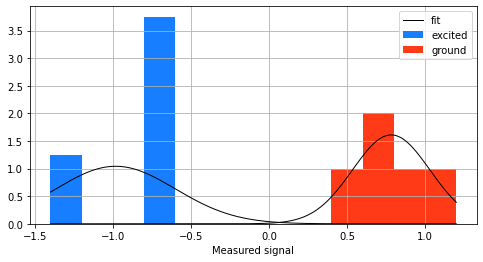

In [163]:
f, ax = plt.subplots(figsize=(8, 4))
noisy_signal_e = signal_out_e
noisy_signal_g = signal_out_g

# Fit data to normal distribution
mu_e, std_e = norm.fit(noisy_signal_e)
mu_g, std_g = norm.fit(noisy_signal_g)

binwidth = 0.2
lim_min = np.ceil(np.array(noisy_signal_e + noisy_signal_g).min() / binwidth) * binwidth
lim_max = np.ceil(np.array(noisy_signal_e + noisy_signal_g).max() / binwidth) * binwidth
bins = np.arange(lim_min, lim_max + binwidth, binwidth)

ax.hist(noisy_signal_e, density=True, color = '#177FFF', bins=bins, label = 'excited')
ax.hist(noisy_signal_g, density=True, color = '#FF3A17', bins=bins, label = 'ground')

x = np.linspace(lim_min, lim_max, 500)
p_e = norm.pdf(x, mu_e, std_e)
plt.plot(x, p_e, 'k', linewidth=1., label = 'fit')
p_g = norm.pdf(x, mu_g, std_g)
plt.plot(x, p_g, 'k', linewidth=1.)

print('Estimation from collected data:')
print('mu_e: %.2f, std_e: %.2f' % (mu_e, std_e))
print('mu_g: %.2f, std_g: %.2f' % (mu_g, std_g))

plt.xlabel('Measured signal')

plt.legend()
plt.grid()
plt.show()

### - Integrated signal
int_signal_out 

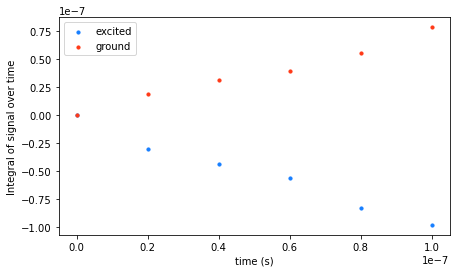

In [164]:
f, ax = plt.subplots(figsize=(7,4))

ax.scatter(acq_time + [dt_acq*len(acq_time)], int_signal_out_e, label = 'excited', c = '#177FFF', s = 10)
ax.scatter(acq_time + [dt_acq*len(acq_time)], int_signal_out_g, label = 'ground', c = '#FF3A17', s = 10)

plt.ylabel(r"Integral of signal over time")
plt.xlabel('time (s)')
plt.legend()
plt.show()

## Multiple readouts

In [165]:
N = 500

# Simulate N readouts for transmon in excited state
q_state = 1
int_signal_data_e, acq_steps_data_e, gaussian_fit_e, error_rate_e, acq_time = sim.do_multiple_readouts(q_state, N, t_wait, t_acq, dt_acq)

# Simulate N readouts for transmon in ground state
q_state = 0
int_signal_data_g, acq_steps_data_g, gaussian_fit_g, error_rate_g, acq_time = sim.do_multiple_readouts(q_state, N, t_wait, t_acq, dt_acq)

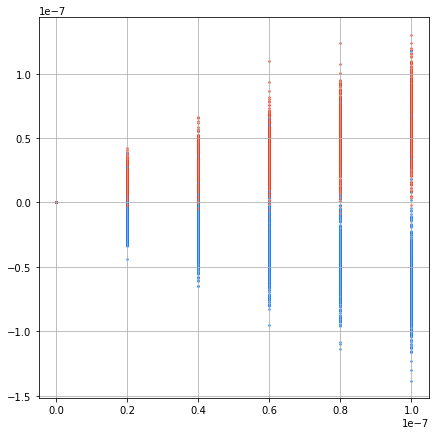

In [167]:
f, ax = plt.subplots(figsize=(7,7))

for n in range(N):
    ax.scatter(acq_time + [dt_acq*len(acq_time)], int_signal_data_e[n], label = 'excited', c = '#177FFF', s = 2)
    ax.scatter(acq_time + [dt_acq*len(acq_time)], int_signal_data_g[n], label = 'ground', c = '#FF3A17', s = 2)

plt.grid()
plt.show()

### Histogram of integrated signal values and fit to gaussian as a function of acquisition steps
acq_steps_data

gaussian_fit

-1.1124770065740649e-08 1.2038806014410443e-08
-2.3208661739511257e-08 2.424271510480049e-08
-3.5202275803691884e-08 3.6985464920763174e-08


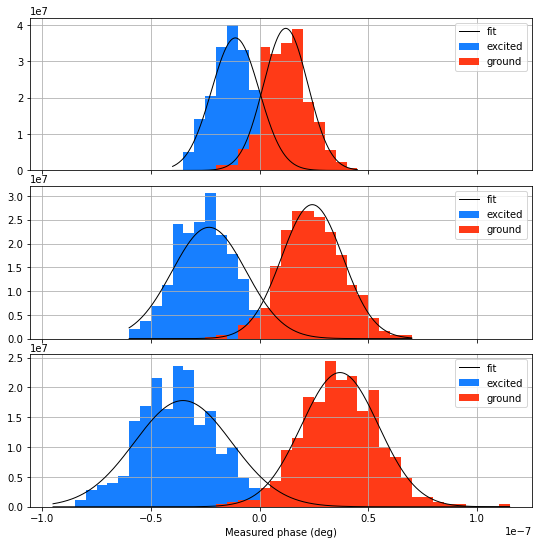

In [168]:
f, axes = plt.subplots(3, 1, sharex=True, figsize=(9,9))
f.subplots_adjust(hspace=0.1)

for n in range(3):
    # Fit data to normal distribution
    mu_e, std_e = gaussian_fit_e[n]
    mu_g, std_g = gaussian_fit_g[n]
    print(mu_e, mu_g)
    binwidth = 5e-9
    lim_min = np.ceil(np.array(acq_steps_data_e[n+1] + acq_steps_data_g[n+1]).min() / binwidth) * binwidth
    lim_max = np.ceil(np.array(acq_steps_data_e[n+1] + acq_steps_data_g[n+1]).max() / binwidth) * binwidth
    bins = np.arange(lim_min, lim_max + binwidth, binwidth)

    axes[n].hist(acq_steps_data_e[n+1], density=True, color = '#177FFF', bins=bins, label = 'excited')
    axes[n].hist(acq_steps_data_g[n+1], density=True, color = '#FF3A17', bins=bins, label = 'ground')

    x = np.linspace(lim_min, lim_max, 500)
    p_e = norm.pdf(x, mu_e, std_e)
    axes[n].plot(x, p_e, 'k', linewidth=1., label = 'fit')
    p_g = norm.pdf(x, mu_g, std_g)
    axes[n].plot(x, p_g, 'k', linewidth=1.)
    axes[n].grid()
    axes[n].legend()

axes[n].set_xlabel('Measured phase (deg)')
plt.show()

### Estimation of state discrimination fidelity using theoretical expected phase boundary
error_rate


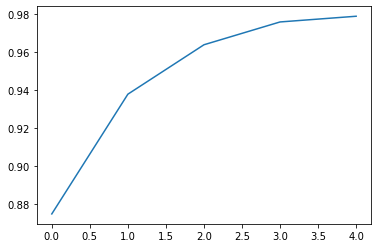

In [170]:
fidelity = []
for i in range(len(error_rate_e)):
    fidelity.append(1 - (error_rate_e[i] + error_rate_g[i])/2)
    
plt.plot(fidelity)